In [1]:
pip install xgboost lightgbm category_encoders

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/63/ca/37b83f59b0efd919c03c52ad7e2473dced674f2f6eb07b9d6f7d80e4c54c/xgboost-2.0.2-py3-none-manylinux2014_x86_64.whl.metadata
  Using cached xgboost-2.0.2-py3-none-manylinux2014_x86_64.whl.metadata (2.0 kB)
  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/b8/9d/1ce80cee7c5ef60f2fcc7e9fa97f29f7a8de3dc5a08922b3b2f1e9106481/lightgbm-4.1.0-py3-none-manylinux_2_28_x86_64.whl.metadata
  Using cached lightgbm-4.1.0-py3-none-manylinux_2_28_x86_64.whl.metadata (19 kB)
  Obtaining dependency information for category_encoders from https://files.pythonhosted.org/packages/7f/e5/79a62e5c9c9ddbfa9ff5222240d408c1eeea4e38741a0dc8343edc7ef1ec/category_encoders-2.6.3-py2.py3-none-any.whl.metadata
Using cached xgboost-2.0.2-py3-none-manylinux2014_x86_64.whl (297.1 MB)
Using cached lightgbm-4.1.0-py3-none-manylinux_2_28_x86_64.whl (3.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import pandas as pd
from category_encoders import TargetEncoder
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [3]:
train = pd.read_csv("train-data.csv", sep = ";")
X_test = pd.read_csv("X_test.csv", sep = ";")

#First, drop duplicates
train = train.drop_duplicates()
X_test = X_test.drop_duplicates()

print(f"Total dataset length is {len(train) + len(X_test)}.")

Total dataset length is 2203713.


In [4]:
train.head(10)

,index,id_product,Region,Country,Site,Operations,Zone,Cluster,Reference proxy,Product Line proxy,Division proxy,Customer Persona proxy,Strategic Product Family proxy,Product Life cycel status,Date,Month 1,Month 2,Month 3,Month 4
0,645874,156160,EUROPE,DE,NL_DC_Venray,Europe Operations,DACH,Germany,reference-13523,Product Line-4,Division-3,Customer Segmentation-3,Strategic Product Family-12,NaN,may-aug 2021,0,0,0,0
1,469488,224631,CHINA,CN,CN_DC_Shanghai,China Operations,China & HK,China,reference-12778,Product Line-4,Division-3,Customer Segmentation-14,Strategic Product Family-9,NaN,jan-apr 2021,0,1,0,0
2,348904,104047,EUROPE,GB,NL_DC_HLD,Europe Operations,UK and Ireland,United Kingdom,reference-3513,Product Line-3,Division-2,Customer Segmentation-23,Strategic Product Family-7,NaN,jan-apr 2021,0,2,0,0
3,1725822,11823,EAJP,AU,AU_DC_Perth,International Operations,Pacific,Australia,reference-672,Product Line-1,Division-1,Customer Segmentation-11,Strategic Product Family-3,NaN,jan-apr 2023,0,0,0,0
4,404781,159924,EUROPE,ES,NL_DC_HLD,Europe Operations,Iberia,Spain,reference-3496,Product Line-3,Division-2,Customer Segmentation-14,Strategic Product Family-7,NaN,jan-apr 2021,0,0,0,0
5,149445,149445,EUROPE,ES,ES_DC_IberiaSantBoi,Europe Operations,Iberia,Spain,reference-7529,Product Line-4,Division-3,Customer Segmentation-3,Strategic Product Family-9,NPI,sep-dec 2020,0,0,0,0
6,1004752,25324,EAJP,AU,AU_DC_Sydney,International Operations,Pacific,Australia,reference-1882,Product Line-1,Division-1,Customer Segmentation-7,Strategic Product Family-4,NaN,jan-apr 2022,0,0,2,0
7,168061,168061,EUROPE,NL,NL_DC_Venray,Europe Operations,BeNe,Netherlands,reference-10764,Product Line-4,Division-3,Customer Segmentation-15,Strategic Product Family-12,NaN,sep-dec 2020,0,0,0,0
8,799510,64939,NAM,US,US_DC_Mechanicsburg,North America Operations,US,USA,reference-6848,Product Line-4,Division-3,Customer Segmentation-4,Strategic Product Family-9,NPI,sep-dec 2021,0,0,0,0
9,1119813,140385,EUROPE,DE,DE_FO_BNDch,Europe Operations,DACH,Germany,reference-6404,Product Line-4,Division-3,Customer Segmentation-1,Strategic Product Family-12,NaN,jan-apr 2022,0,0,0,0


## Drop useless features

Some features don't add any information to the prediction of the 4th month of sale. So we're going to delete them.

In [12]:
train.drop(columns=['index', 'Cluster'], inplace=True)
X_test.drop(columns=['index', 'Cluster'], inplace=True)

## Merge extra datasets with the train set

#### Some useful variables used throughout the merges

In [13]:
dates = train['Date'].unique().tolist()

country_mapping = {
    'DE': 'Germany',
    'CN': 'China',
    'GB': 'United Kingdom',
    'AU': 'Australia',
    'ES': 'Spain',
    'NL': 'Netherlands',
    'US': 'United States',
    'DK': 'Denmark',
    'BE': 'Belgium',
    'FR': 'France',
    'IT': 'Italy',
    'PL': 'Poland',
    'SE': 'Sweden',
    'TW': 'Taiwan',
    'JP': 'Japan',
    'HK': 'Hong Kong',
    'KR': 'Korea, Rep.',
    'PH': 'Philippines',
    'MY': 'Malaysia',
    'SG': 'Singapore',
    'TH': 'Thailand',
    'Id': 'Indonesia',
    'FJ': 'Fiji',
    'VN': 'Vietnam',
    'BN': 'Brunei Darussalam',
    'NZ': 'New Zealand',
    'MM': 'Myanmar',
    'KH': 'Cambodia',
    'MN': 'Mongolia',
    'LA': 'Laos',
    'PG': 'Papua New Guinea'
}

inverted_country_mapping = {v: k for k, v in country_mapping.items()}

sites = train['Site'].unique().tolist()

### LPIExtend dataset

In [14]:
LPI = pd.read_csv('./extra-dataset/LPIextend.csv').drop(['Unnamed: 0', 'ID'], axis=1)

LPI['Country'] = LPI['Country'].apply(lambda x: 'Brunei Darussalam' if x == 'Brunei' else x)
LPI = LPI.loc[LPI['Country'].isin(country_mapping.values())]
rel_cols = ['Country', 'unMember', 'netChange', 'growthRate', 'worldPercentage', 'density', 'rank', 'Customs Score', 'Infrastructure Score', 'International Shipments Score', 'Logistics Competence and Quality Score', 'Timeliness Score', 'Tracking and Tracing Score']

LPI = LPI.loc[:, rel_cols]
LPI.at[133, 'unMember'] = True
for col in rel_cols[2:]:
    LPI[col].fillna(LPI[col].mean(), inplace=True)

LPI = LPI.reset_index(drop=True)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

subset_df = LPI[rel_cols[1:]]

scaler = StandardScaler()
subset_df_scaled = scaler.fit_transform(subset_df)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(subset_df_scaled)

LPI['Country'] = LPI['Country'].apply(lambda x: inverted_country_mapping[x])

pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(2)])
final_lpi = pd.concat([LPI['Country'], pca_df['PC1'], pca_df['PC2']], axis=1)

train = pd.merge(train, final_lpi, how = 'left', on = "Country")
X_test = pd.merge(X_test, final_lpi, how = 'left', on = "Country")

#### Worldbank economic dataset

In [17]:
worldbank_eco = pd.read_csv("./extra-dataset/worldbank_economic_data.csv")
worldbank_eco.columns

worldbank_eco = pd.read_csv("./extra-dataset/worldbank_economic_data.csv")

#Rename columns so that its actually manipulable 
features_name = {'Exports of goods and services (annual % growth)' : 'Exports',
                 'GDP (current US$)' : 'GDP',
                 'Imports of goods and services (annual % growth)' : 'Imports',
                 'Industry (including construction), value added (annual % growth)': 'Industry',
                 'Manufacturing, value added (annual % growth)' : 'Manufacturing',
                 'Services, value added (annual % growth)': 'Services'}
                 
worldbank_eco.rename(columns=features_name, inplace=True)

#Keeping the columns that we considered the most interesting, and the keys.
worldbank_eco = worldbank_eco[['Country', 'Year', 'Exports', 'Imports', 'GDP', 'Industry', 'Manufacturing','Services']]

#Converting dates to the time spans of the train dataset
worldbank_eco['Date'] = 0

for index, row in worldbank_eco.iterrows():
    year = row['Year']
    country = worldbank_eco.loc[index,'Country']

    if country in country_mapping.values():
        worldbank_eco.loc[index,'Country'] = inverted_country_mapping[country]
    else:
        worldbank_eco = worldbank_eco.drop(index)
        pass

    for date in dates:
        if str(year) in date:
            worldbank_eco.loc[index, 'Date'] = date
            worldbank_eco.loc[len(worldbank_eco)] = worldbank_eco.loc[index]

worldbank_eco = worldbank_eco.drop_duplicates()

#NA imputing
impute_columns = []
for column_to_impute in ['Exports', 'Imports', 'GDP', 'Industry', 'Manufacturing','Services']:
    # Step 1: Impute missing values with the average value per country
    worldbank_eco[column_to_impute] = worldbank_eco.groupby('Country')[column_to_impute].transform(lambda x: x.fillna(x.mean()))

    # Step 2: Impute missing values with the international average if the whole country is missing
    worldbank_eco[column_to_impute] = worldbank_eco[column_to_impute].fillna(worldbank_eco[column_to_impute].mean())

    jan_apr_2023_mask = worldbank_eco['Date'] == 'jan-apr 2023'
    may_aug_2022_mask = worldbank_eco['Date'] == 'may-aug 2022'

    # Extract values for "may-aug 2022"
    may_aug_2022_values = worldbank_eco.loc[may_aug_2022_mask, ['Country', column_to_impute]]

    # Merge values for "may-aug 2022" into the main DataFrame for "jan-apr 2023"
    worldbank_eco.loc[jan_apr_2023_mask, column_to_impute] = worldbank_eco.loc[jan_apr_2023_mask, 'Country'].map(
        may_aug_2022_values.set_index('Country')[column_to_impute]
    )
    
#Merge dataset
train = pd.merge(train, worldbank_eco, on=['Country', 'Date'], how='left')
X_test = pd.merge(X_test, worldbank_eco, on=['Country', 'Date'], how='left')
train.pop('Year')
X_test.pop('Year')

for column_to_impute in ['Exports', 'Imports', 'GDP', 'Industry', 'Manufacturing','Services']:
    train[column_to_impute].fillna(train[column_to_impute].mean(), inplace = True)
    X_test[column_to_impute].fillna(X_test[column_to_impute].mean(), inplace = True)

train.head(10)

,id_product,Region,Country,Site,Operations,Zone,Reference proxy,Product Line proxy,Division proxy,Customer Persona proxy,...,Month 4,PC1,PC2,Year,Exports,Imports,GDP,Industry,Manufacturing,Services
0,156160,EUROPE,DE,NL_DC_Venray,Europe Operations,DACH,reference-13523,Product Line-4,Division-3,Customer Segmentation-3,...,0,-2.499656,-0.765950,2021.0,9.710000,9.000000,4.259935e+12,3.61,5.070000,2.27
1,224631,CHINA,CN,CN_DC_Shanghai,China Operations,China & HK,reference-12778,Product Line-4,Division-3,Customer Segmentation-14,...,0,-1.095021,-3.284178,2021.0,5.127357,7.232429,1.782046e+13,8.67,3.032473,8.49
2,104047,EUROPE,GB,NL_DC_HLD,Europe Operations,UK and Ireland,reference-3513,Product Line-3,Division-2,Customer Segmentation-23,...,0,-0.641699,-0.701010,2021.0,2.240000,6.190000,3.122480e+12,9.29,10.080000,7.53
3,11823,EAJP,AU,AU_DC_Perth,International Operations,Pacific,reference-672,Product Line-1,Division-1,Customer Segmentation-11,...,0,-0.512168,-0.162840,2023.0,-0.100000,7.080000,1.675419e+12,1.67,2.540000,4.28
4,159924,EUROPE,ES,NL_DC_HLD,Europe Operations,Iberia,reference-3496,Product Line-3,Division-2,Customer Segmentation-14,...,0,-1.712218,-0.551927,2021.0,14.380000,13.920000,1.427381e+12,4.03,8.910000,5.95
5,149445,EUROPE,ES,ES_DC_IberiaSantBoi,Europe Operations,Iberia,reference-7529,Product Line-4,Division-3,Customer Segmentation-3,...,0,-1.712218,-0.551927,2020.0,-19.940000,-14.850000,1.276963e+12,-13.14,-15.390000,-11.45
6,25324,EAJP,AU,AU_DC_Sydney,International Operations,Pacific,reference-1882,Product Line-1,Division-1,Customer Segmentation-7,...,0,-0.512168,-0.162840,2022.0,-0.100000,7.080000,1.675419e+12,1.67,2.540000,4.28
7,168061,EUROPE,NL,NL_DC_Venray,Europe Operations,BeNe,reference-10764,Product Line-4,Division-3,Customer Segmentation-15,...,0,-2.128553,0.118574,2020.0,-4.330000,-4.750000,9.097935e+11,-2.09,-2.260000,-4.68
8,64939,NAM,US,US_DC_Mechanicsburg,North America Operations,US,reference-6848,Product Line-4,Division-3,Customer Segmentation-4,...,0,-0.963586,-2.246959,2021.0,6.050000,14.130000,2.331508e+13,3.25,6.790000,6.63
9,140385,EUROPE,DE,DE_FO_BNDch,Europe Operations,DACH,reference-6404,Product Line-4,Division-3,Customer Segmentation-1,...,0,-2.499656,-0.765950,2022.0,2.870000,5.990000,4.072192e+12,-0.47,0.200000,2.81


#### Worldbank inflation dataset

In [18]:
wbi = pd.read_csv('./extra-dataset/worldbank_inflation_data.csv')

transformation = {'Lao, PDR': 'Laos', 'Taiwan, China': 'Taiwan', 'Hong Kong SAR, China': 'Hong Kong'}
wbi['Country'] = wbi['Country'].apply(lambda x: transformation[x] if x in transformation.keys() else x)

 # Apply country mapping and keep only the associated data
train['Country'] = train['Country'].apply(lambda x: country_mapping[x])
X_test['Country'] = X_test['Country'].apply(lambda x: country_mapping[x])
wbi = wbi.loc[wbi['Country'].isin(country_mapping.values())]

 # Extract the date info
wbi['Year'] = wbi['Year-Month'].apply(lambda x: int(x[:4]))
wbi['Month'] = wbi['Year-Month'].apply(lambda x: int(x[-2:]))

 # Drop data out of the relevant temporal window
cond = (wbi['Year'] == 2020) & (wbi['Month'] <= 9)
wbi.drop(wbi[cond].index, inplace=True)
cond2 = (wbi['Year'] == 2023) & (wbi['Month'] >= 8)
wbi.drop(wbi[cond2].index, inplace=True)

# Create the quarter variable for the incoming temporal average
wbi['Quarter'] = wbi['Year-Month'].apply(lambda x: (int(x[-2:]) - 1) // 4)


 # Temporal average of the indexes
gped = wbi.groupby(['Country', 'Year', 'Quarter'])[['Energy Price Index', "Headline Consumer Price Index"]].mean()

# Useful quantities (default value if there is a NaN)
month_map = {'jan': 0, 'may': 1, 'sep': 2}
mean_epi = wbi['Energy Price Index'].mean()
mean_hcpi = wbi['Headline Consumer Price Index'].mean()

def transfo_index(x, default_val, key):
    index = (x['Country'],
             int(x['Date'].split()[-1]),
             month_map[x['Date'].split()[0].split('-')[0]])
    
    if index in gped.index:
        return gped.loc[index][key]
    return default_val

# Apply final transformation and replace NaNs with global mean
def final_transfo(df):
    df['EPI'] = df.apply(lambda x: transfo_index(x, mean_epi, 'Energy Price Index'), axis=1)
    df['EPI'].fillna(mean_epi, inplace=True)

    df['HCPI'] = df.apply(lambda x: transfo_index(x, mean_hcpi, 'Headline Consumer Price Index'), axis=1)
    df['HCPI'].fillna(mean_hcpi, inplace=True)
    return df

train = final_transfo(train)
X_test = final_transfo(X_test)

#### GSCPI Dataset

In [19]:
gscpi = pd.read_csv("./extra-dataset/GSCPI_data.csv")

gscpi['Year-Month'] = pd.to_datetime(gscpi['Year-Month'])

# Define a function to map each date to its corresponding time span
def map_to_time_span(date):
    if date.month in [5, 6, 7, 8] and date.year == 2021:
        return 'may-aug 2021'
    elif date.month in [1, 2, 3, 4] and date.year == 2021:
        return 'jan-apr 2021'
    elif date.month in [1, 2, 3, 4] and date.year == 2023:
        return 'jan-apr 2023'
    elif date.month in [9, 10, 11, 12] and date.year == 2020:
        return 'sep-dec 2020'
    elif date.month in [1, 2, 3, 4] and date.year == 2022:
        return 'jan-apr 2022'
    elif date.month in [9, 10, 11, 12] and date.year == 2021:
        return 'sep-dec 2021'
    elif date.month in [9, 10, 11, 12] and date.year == 2022:
        return 'sep-dec 2022'
    elif date.month in [5, 6, 7, 8] and date.year == 2022:
        return 'may-aug 2022'
    elif date.month in [5, 6, 7] and date.year == 2023:
        return 'may-jul 2023'
    else:
        return None

# Map each date to its corresponding time span and create a new column in gscpi
gscpi['Time Span'] = gscpi['Year-Month'].apply(map_to_time_span)

# Drop rows where Time Span is None
gscpi = gscpi.dropna(subset=['Time Span'])

# Compute the average gscpi_val for each time span
average_gscpi = gscpi.groupby('Time Span')['GSCPI'].mean().reset_index()

# Merge the average_gscpi dataframe with the train dataframe
train = pd.merge(train, average_gscpi, how='left', left_on='Date', right_on='Time Span')
X_test = pd.merge(X_test, average_gscpi, how='left', left_on='Date', right_on='Time Span')

# Drop unnecessary columns
train = train.drop(['Time Span'], axis=1)
X_test = X_test.drop(['Time Span'], axis=1)

# Display the updated train dataframe
train.head(10)

,id_product,Region,Country,Site,Operations,Zone,Reference proxy,Product Line proxy,Division proxy,Customer Persona proxy,...,Year,Exports,Imports,GDP,Industry,Manufacturing,Services,EPI,HCPI,GSCPI
0,156160,EUROPE,Germany,NL_DC_Venray,Europe Operations,DACH,reference-13523,Product Line-4,Division-3,Customer Segmentation-3,...,2021.0,9.710000,9.000000,4.259935e+12,3.61,5.070000,2.27,108.703500,108.696750,2.957795
1,224631,CHINA,China,CN_DC_Shanghai,China Operations,China & HK,reference-12778,Product Line-4,Division-3,Customer Segmentation-14,...,2021.0,5.127357,7.232429,1.782046e+13,8.67,3.032473,8.49,100.875000,129.505090,2.030159
2,104047,EUROPE,United Kingdom,NL_DC_HLD,Europe Operations,UK and Ireland,reference-3513,Product Line-3,Division-2,Customer Segmentation-23,...,2021.0,2.240000,6.190000,3.122480e+12,9.29,10.080000,7.53,106.800000,109.700000,2.030159
3,11823,EAJP,Australia,AU_DC_Perth,International Operations,Pacific,reference-672,Product Line-1,Division-1,Customer Segmentation-11,...,2023.0,-0.100000,7.080000,1.675419e+12,1.67,2.540000,4.28,122.997285,126.769292,-0.430277
4,159924,EUROPE,Spain,NL_DC_HLD,Europe Operations,Iberia,reference-3496,Product Line-3,Division-2,Customer Segmentation-14,...,2021.0,14.380000,13.920000,1.427381e+12,4.03,8.910000,5.95,101.715300,104.850000,2.030159
5,149445,EUROPE,Spain,ES_DC_IberiaSantBoi,Europe Operations,Iberia,reference-7529,Product Line-4,Division-3,Customer Segmentation-3,...,2020.0,-19.940000,-14.850000,1.276963e+12,-13.14,-15.390000,-11.45,93.161100,104.266667,0.784687
6,25324,EAJP,Australia,AU_DC_Sydney,International Operations,Pacific,reference-1882,Product Line-1,Division-1,Customer Segmentation-7,...,2022.0,-0.100000,7.080000,1.675419e+12,1.67,2.540000,4.28,122.997285,126.769292,3.117173
7,168061,EUROPE,Netherlands,NL_DC_Venray,Europe Operations,BeNe,reference-10764,Product Line-4,Division-3,Customer Segmentation-15,...,2020.0,-4.330000,-4.750000,9.097935e+11,-2.09,-2.260000,-4.68,102.373333,107.966667,0.784687
8,64939,NAM,United States,US_DC_Mechanicsburg,North America Operations,US,reference-6848,Product Line-4,Division-3,Customer Segmentation-4,...,2021.0,6.050000,14.130000,2.331508e+13,3.25,6.790000,6.63,125.541750,116.825000,3.897540
9,140385,EUROPE,Germany,DE_FO_BNDch,Europe Operations,DACH,reference-6404,Product Line-4,Division-3,Customer Segmentation-1,...,2022.0,2.870000,5.990000,4.072192e+12,-0.47,0.200000,2.81,133.327750,112.834750,3.117173


## Convert Months to proper type and use linear regression to impute NA Month 1 values.

In [20]:
imputed_mask = train['Month 1'].isna()
train['M_1_Imputed'] = np.where(imputed_mask, 1, 0)

imputed_mask = X_test['Month 1'].isna()
X_test['M_1_Imputed'] = np.where(imputed_mask, 1, 0)

def month_impute_and_convert(df):
    
    months = [col for col in df.columns if "Month" in col]
    data_month = df[months].copy()
    for m in months:
        data_month[m] = data_month[m].str.replace(" ", "")
        data_month[m] = pd.to_numeric(data_month[m])
        
    if df.equals(train):
        X = data_month.drop(["Month 1", "Month 4"], axis=1)
    else:
        X = data_month.drop(["Month 1"], axis=1)
    y = data_month["Month 1"]

    X_train = data_month.dropna(subset=["Month 1"])[["Month 2", "Month 3"]]
    y_train = y[X_train.index]

    X_test = X[pd.isna(data_month["Month 1"])]
    y_test = y[X_test.index]

    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    vals = lin_reg.predict(X_test)

    df["Month 1"] = data_month["Month 1"].copy()
    df.loc[X_test.index, "Month 1"] = vals.copy()
    
    if df.equals(train):
        df.loc[:, ["Month 2", "Month 3", "Month 4"]] = data_month.loc[:, ["Month 2", "Month 3", "Month 4"]].astype(int)
    else: 
        df.loc[:, ["Month 2", "Month 3"]] = data_month.loc[:, ["Month 2", "Month 3"]].astype(int)
    return df
    
train = month_impute_and_convert(train)
X_test = month_impute_and_convert(X_test)

## Feature encoding

We're going to encode categorical features.

* All geographical features: We might replace all those features by longitude and latitude coordinates in order to reduce features and to establish actual euclidian distance between observations.

* Reference proxy: Since there are too many proxies (22406), we're not going to one hot encode it but rather use target encoding.

* Division proxy: Since there are only 3 divisions, we're going to one hot encode this feature.

* Product line proxy: Since there are only 6 different lines, we're going to one hot encode this feature.

* Customer Persona proxy: there are 72 different values. We're going to use target encoding.

* Strategic Product Family proxy: There are 19 different values. We can discuss on whether to use target or one hot encoding.

* Product life cycle: There are 4 different values including NaN which is actually the most proeminent. Therefore, we're going to impute the NaN as an "Active" class and we're going to one hot encode the feature.

* Date: There are 9 diferent time spans. We can encode them ordinally.

In [21]:
def preprocess_data(df, encoder=None):
    # Target Encoding
    tgt_encode_columns = ['id_product', 'Reference proxy', 'Customer Persona proxy', 'Strategic Product Family proxy']

    if encoder is None:
        encoder = TargetEncoder(cols=tgt_encode_columns)
        df_encoded = encoder.fit_transform(df, y_train)
    else:
        df_encoded = encoder.transform(df)

    # Update the original DataFrame with the encoded values
    df[tgt_encode_columns] = df_encoded[tgt_encode_columns]

    # Fill NA with "Unknown" Value for Product life cycle
    df['Product Life cycel status'].fillna('Active', inplace=True)

    # One hot encoding
    one_hot_encode_cols = ['Division proxy', 'Product  Line proxy', 'Product Life cycel status']
    df = pd.get_dummies(df, columns=one_hot_encode_cols)

    # Date
    date_set = {'may-aug 2021': 2, 'jan-apr 2021': 1, 'jan-apr 2023': 7, 'sep-dec 2020': 0,
                'jan-apr 2022': 4, 'sep-dec 2021': 3, 'sep-dec 2022': 6, 'may-aug 2022': 5, 'may-jul 2023': 8}
    df['Date'] = df['Date'].apply(lambda x: date_set[x])

    return df, encoder

y_train = train.pop('Month 4')
X_train = train.copy()
del(train)

X_train, encoder = preprocess_data(X_train)
X_test, _ = preprocess_data(X_test, encoder)

#### Replace geographical features by latitude & longitude + site type

In [22]:
#Import centers localisation and preprocess
centers_loc = pd.read_csv('distribution_centers.csv')
centers_loc.drop(columns = ['City', 'Country'], inplace = True)

#Import center types and preprocess
center_types = pd.read_csv('locations_combined.csv')
center_types.drop(columns = ['Country'], inplace = True)
center_types.rename(columns={'Location': 'Site'}, inplace=True)

def extract_between_parentheses(input_string):
    last_left_parenthesis = input_string.rfind('(')
    last_right_parenthesis = input_string.rfind(')')

    if last_left_parenthesis != -1 and last_right_parenthesis != -1:
        result = input_string[last_left_parenthesis + 1:last_right_parenthesis]
        return result
    else:
        return None

for index, row in center_types.iterrows():
    location = row['Site']
    center_types.loc[index, 'Site'] = extract_between_parentheses(location)

def insert_geo_features(df):
    df.drop(columns = ["Region", "Country", "Operations", "Zone"], inplace = True)
    df = pd.merge(df, center_types, on= 'Site', how = 'left')
    df = pd.merge(df, centers_loc, on = 'Site', how = 'left')
    df.pop('Site')
    return df
    
X_train = insert_geo_features(X_train)
X_test = insert_geo_features(X_test)

In [23]:
def convert_to_num(df):
    object_columns = df.select_dtypes(include=['object']).columns

    # Convert object columns to numeric
    df[object_columns] = df[object_columns].apply(pd.to_numeric)
    
    return df

X_train = convert_to_num(X_train)
X_test = convert_to_num(X_test)
y_train = y_train.apply(pd.to_numeric)

In [2]:
X_train.to_csv('my_X_train.csv')
y_train.to_csv('my_y_train.csv')
X_test.to_csv('my_X_test.csv')

NameError: name 'X_train' is not defined

In [3]:
X_train = pd.read_csv('my_X_train.csv')
y_train = pd.read_csv('my_y_train.csv')
X_test = pd.read_csv('my_X_test.csv')
X_train.pop('Unnamed: 0')
X_test.pop('Unnamed: 0')
y_train.pop('Unnamed: 0')

0                0
1                1
2                2
3                3
4                4
            ...   
1762965    1762965
1762966    1762966
1762967    1762967
1762968    1762968
1762969    1762969
Name: Unnamed: 0, Length: 1762970, dtype: int64

In [4]:
for column_to_impute in ['Exports', 'Imports', 'GDP', 'Industry', 'Manufacturing','Services']:
    X_train[column_to_impute].fillna(X_train[column_to_impute].mean(), inplace = True)
    X_test[column_to_impute].fillna(X_test[column_to_impute].mean(), inplace = True)

X_train.pop('Year')
X_test.pop('Year')

0         2021.0
1         2023.0
2         2023.0
3         2021.0
4         2022.0
           ...  
440738    2021.0
440739    2022.0
440740    2022.0
440741    2022.0
440742    2020.0
Name: Year, Length: 440743, dtype: float64

# Models hyperparameter tuning

In [ ]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Define the LightGBM model
lgb_model = lgb.LGBMRegressor()

# Define the hyperparameter grid
param_dist = {
    'n_estimators': sp.stats.randint(100, 400),
    'max_depth': sp.stats.randint(5, 20),
    'num_leaves': sp.stats.randint(30, 70),  # Adjust the range as needed
    'learning_rate': sp.stats.loguniform(1e-3,1e-1),
    'subsample': sp.stats.uniform(0.5, 0.5),
    'colsample_bytree': sp.stats.uniform(0.7, 0.3),
    'reg_alpha': sp.stats.uniform(0, 0.3),
    'reg_alpha': sp.stats.uniform(0, 0.3)
}

# Set up RandomizedSearchCV
lgbm_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=700,  # Adjust the number of iterations as needed
    scoring='neg_root_mean_squared_error',  # Use an appropriate scoring metric for your problem
    cv=3,  # Number of cross-validation folds
    random_state=42,
)

# Fit the model to the data
lgbm_search.fit(X_train, y_train)

<Axes: >

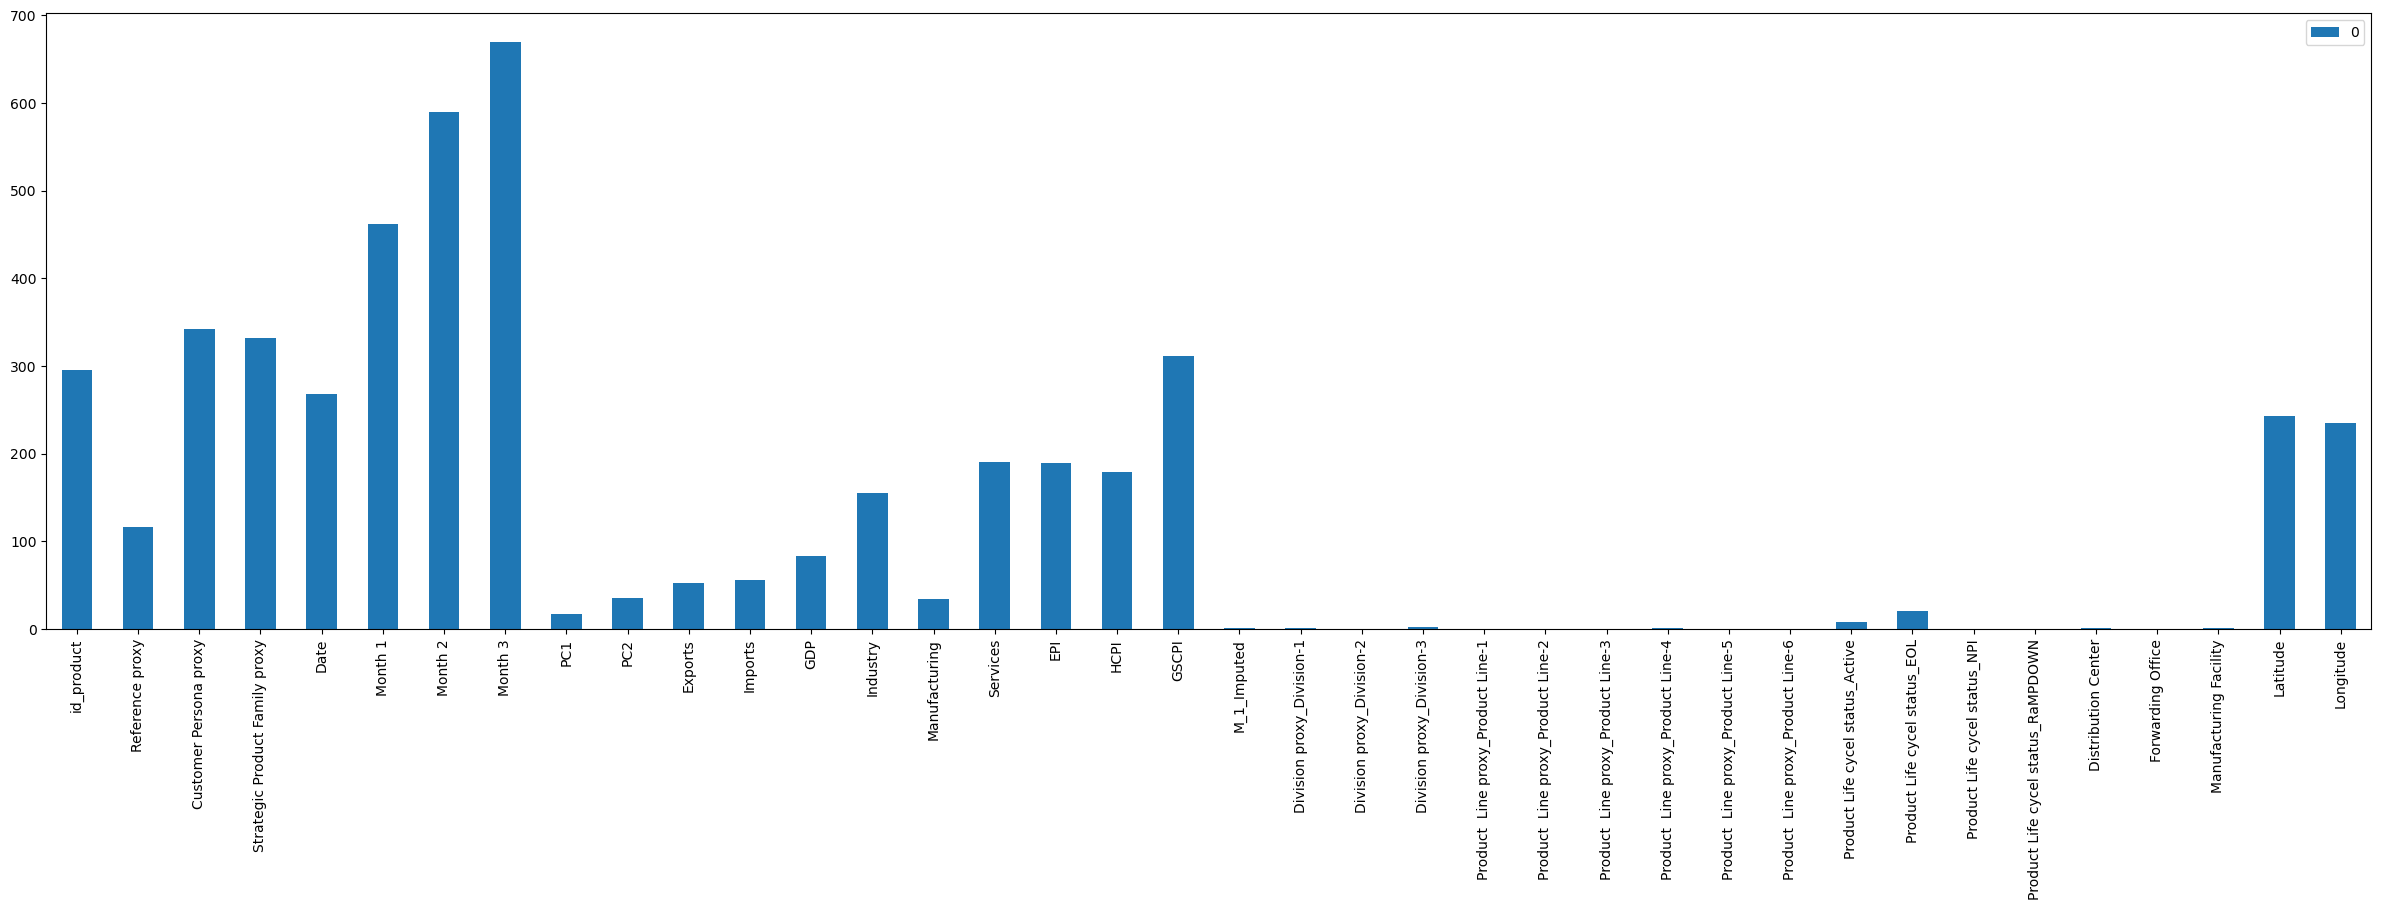

In [20]:
pd.DataFrame(lgbm_search.best_estimator_.feature_importances_, index=X_train.columns).plot.bar(figsize=(30, 8))

In [21]:
print(lgbm_search.best_params_)
results = pd.DataFrame(lgbm_search.cv_results_)
results.sort_values('rank_test_score')

{'colsample_bytree': 0.7170644193332939, 'learning_rate': 0.03412358349737991, 'max_depth': 10, 'n_estimators': 153, 'num_leaves': 33, 'reg_alpha': 0.11878116785878495, 'subsample': 0.8781268957112172}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_num_leaves,param_reg_alpha,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
683,5.197205,0.108972,0.773682,0.092208,0.717064,0.034124,10,153,33,0.118781,0.878127,"{'colsample_bytree': 0.7170644193332939, 'lear...",-517.737838,-532.440871,-428.962013,-493.046907,45.710685,1
310,4.226228,0.104907,0.664187,0.028616,0.703309,0.031557,9,119,40,0.226879,0.920985,"{'colsample_bytree': 0.7033094842787397, 'lear...",-519.420089,-533.590741,-430.319881,-494.443570,45.709864,2
281,5.908403,0.105670,0.825302,0.024024,0.730314,0.024228,16,196,33,0.189957,0.614447,"{'colsample_bytree': 0.730313743303194, 'learn...",-521.438364,-534.852971,-428.351929,-494.881088,47.360917,3
624,7.663993,0.134317,0.974093,0.024645,0.786402,0.012962,16,289,33,0.125755,0.584102,"{'colsample_bytree': 0.7864016037772124, 'lear...",-520.195756,-534.401167,-430.343255,-494.980059,46.071580,4
73,10.507583,0.158794,1.377975,0.050175,0.733359,0.009666,17,341,57,0.171442,0.870487,"{'colsample_bytree': 0.7333592446918453, 'lear...",-520.119001,-534.756341,-430.243957,-495.039766,46.205596,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,5.161351,0.153999,0.733952,0.035775,0.769888,0.001119,14,133,59,0.000071,0.592736,"{'colsample_bytree': 0.7698878424260901, 'lear...",-679.368757,-696.531896,-580.283425,-652.061359,51.236037,696
679,4.759523,0.081968,0.681199,0.072649,0.720008,0.001248,14,110,67,0.156964,0.635893,"{'colsample_bytree': 0.7200081644216346, 'lear...",-682.272651,-700.025446,-583.532584,-655.276894,51.245975,697
5,5.030894,0.299406,0.815986,0.076390,0.83515,0.001063,13,113,38,0.00479,0.615447,"{'colsample_bytree': 0.8351497755908628, 'lear...",-685.831558,-702.914440,-586.899834,-658.548611,51.141090,698
98,3.922713,0.230808,0.561625,0.058289,0.804286,0.001158,10,100,34,0.138234,0.603167,"{'colsample_bytree': 0.804285764344805, 'learn...",-686.923671,-704.335503,-588.147049,-659.802074,51.163952,699


In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the Lasso Regression model
lasso_model = Lasso()

# Define the hyperparameter grid
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=lasso_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # Use an appropriate scoring metric for your problem
    cv=5
)

# Fit the model to the data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters found
print("Best Parameters: ", grid_search.best_params_)

# Get the best Lasso model
best_lasso_model = grid_search.best_estimator_

# Plot feature importances
coef = best_lasso_model.coef_
features = X_train.columns.values

plt.figure(figsize=(10, 6))
plt.barh(features, np.abs(coef))
plt.xlabel('Absolute Coefficient Magnitude')
plt.title('Lasso Regression Feature Importances')
plt.show()

In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values('rank_test_score')

In [ ]:
# Define the XGBoost model
xgb_model = xgb.XGBRegressor()

# Define the hyperparameter grid
param_dist = {
    'learning_rate': sp.stats.loguniform(1e-3,5e-2),
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': sp.stats.randint(5,20),
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0],
    'scale_pos_weight': [1, 2, 3]
}

# Set up RandomizedSearchCV
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,  # Adjust the number of iterations as needed
    scoring='neg_root_mean_squared_error',  # Use an appropriate scoring metric for your problem
    cv=3,  # Number of cross-validation folds
    random_state=42,
    verbose = 3
)

# Fit the model to the data
xgb_random_search.fit(X_train, y_train)

<Axes: >

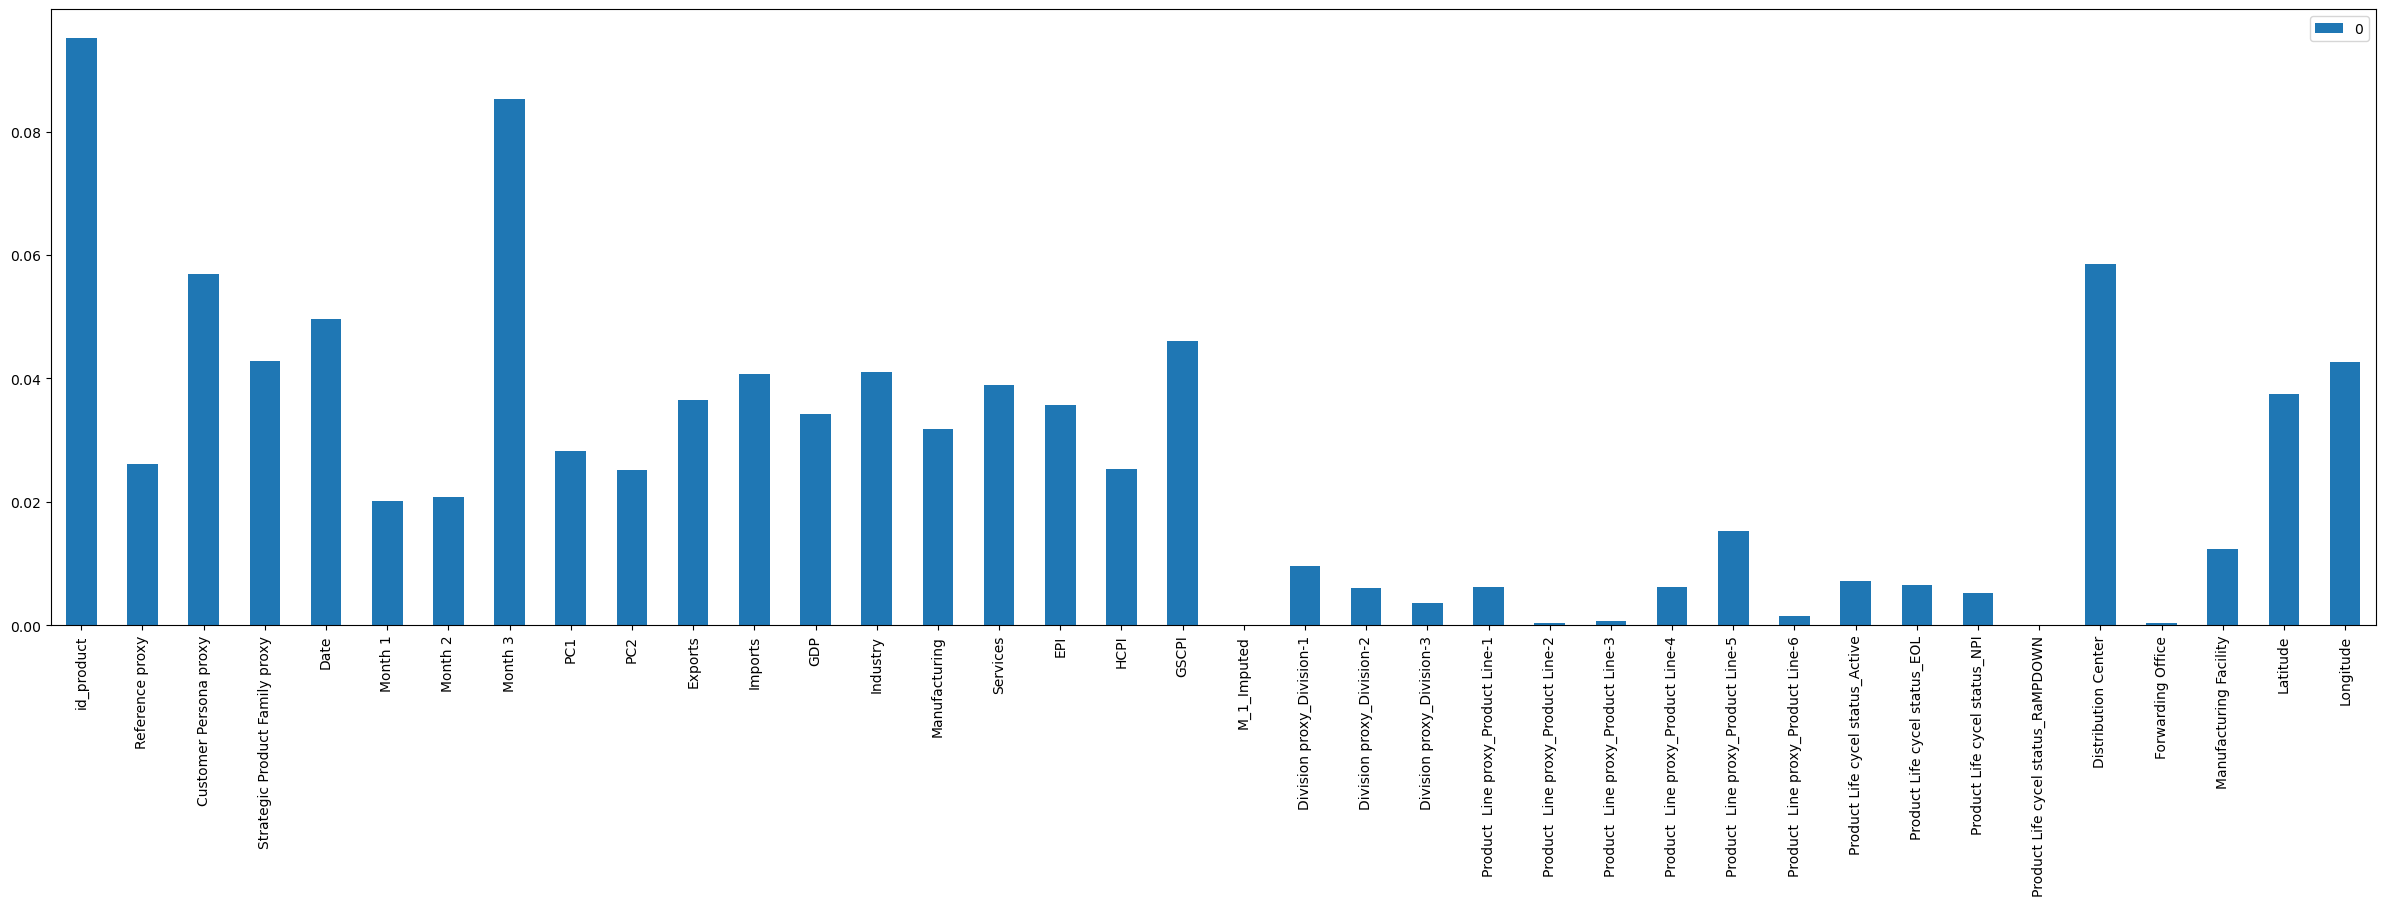

In [28]:
pd.DataFrame(xgb_random_search.best_estimator_.feature_importances_, index=X_train.columns).plot.bar(figsize=(30, 8))

In [14]:
print(xgb_random_search.best_params_)
results = pd.DataFrame(xgb_random_search.cv_results_)
results.sort_values('rank_test_score')

{'subsample': 1.0, 'scale_pos_weight': 3, 'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimators': 50, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 1.0}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_scale_pos_weight,param_reg_lambda,param_reg_alpha,param_n_estimators,param_min_child_weight,...,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,8.234261,0.183073,1.760362,0.034915,1.0,3,0,0.1,50,5,...,0.2,0.2,1.0,"{'subsample': 1.0, 'scale_pos_weight': 3, 'reg...",-170950.164475,-158807.824956,-170953.973138,-166903.987523,5724.851664,1
4,21.589066,2.324140,2.939492,0.073365,0.9,2,0.1,0,300,1,...,0.3,0,0.7,"{'subsample': 0.9, 'scale_pos_weight': 2, 'reg...",-170944.625493,-160693.646939,-170986.908335,-167541.726922,4842.354562,2
2,32.235487,0.910664,3.024642,0.116819,0.9,3,0.1,0,400,1,...,0.01,0.2,1.0,"{'subsample': 0.9, 'scale_pos_weight': 3, 'reg...",-175954.926136,-163530.379990,-180235.328331,-173240.211486,7084.776237,3
0,28.571863,1.889771,2.961484,0.171370,1.0,3,0,0.5,400,4,...,0.01,0.2,1.0,"{'subsample': 1.0, 'scale_pos_weight': 3, 'reg...",-176611.026525,-164198.258846,-180905.482127,-173904.922499,7084.023183,4
1,8.962371,0.394989,1.783835,0.135234,0.7,1,0.5,1.0,50,1,...,0.001,0.4,1.0,"{'subsample': 0.7, 'scale_pos_weight': 1, 'reg...",-449181.322831,-441793.162439,-712425.397188,-534466.627486,125871.995863,5


In [ ]:
subset = X_train[0:1000]

y_pred = lgbm_search.best_estimator_.predict(subset)

plt.loglog(y_pred, y_train[0:1000], 'o')

In [ ]:
X_test = pd.read_csv("y_test_example.csv", sep = ";")
X_test["index"]

In [ ]:
y_pred = lgbm_search.best_estimator_.predict(X_test)

In [ ]:
# Define the Random Forest model
rf_model = RandomForestRegressor()

# Define the hyperparameter grid with a wide range of values
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


# Set up RandomizedSearchCV
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,  # Adjust the number of iterations as needed
    scoring='neg_root_mean_squared_error',  # Use an appropriate scoring metric for your problem
    cv=3,  # Number of cross-validation folds
    random_state=42,
    n_jobs=1,
    verbose = 3# Use -1 to utilize all available CPU cores
)

# Fit the model to the data
rf_random_search.fit(X_train, y_train)

In [ ]:
pd.DataFrame(rf_random_search.best_estimator_.feature_importances_, index=X_train.columns).plot.bar(figsize=(30, 8))

In [ ]:
print(rf_random_search.best_params_)
results = pd.DataFrame(rf_random_search.cv_results_)
results.sort_values('rank_test_score')

In [29]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 31.6 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from catboost import CatBoostRegressor

# Assuming you have your features (X) and labels (y) defined

# Define the CatBoost model
catboost_model = CatBoostRegressor()

param_dist = {
    'iterations': sp.stats.randint(50, 500),  # Number of trees
    'learning_rate': sp.stats.loguniform(1e-4,1e-1),
    'depth': sp.stats.randint(1, 10),          # Depth of the trees
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': sp.stats.randint(5, 255),   # Number of splits in a tree node
    'random_strength': [0.1, 0.5, 1, 2, 5],
    'bagging_temperature': [0.0, 1.0, 2.0, 3.0, 4.0],
    # Add more hyperparameters as needed
}

# Perform Randomized Search with 5-fold cross-validation
random_search = RandomizedSearchCV(
    catboost_model, param_distributions=param_dist, n_iter=200,
    scoring='neg_root_mean_squared_error', cv=3, n_jobs=1, random_state=42
)

# Fit the random search to your data
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

In [ ]:
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.sort_values('rank_test_score')

In [ ]:
pd.DataFrame(random_search.best_estimator_.feature_importances_, index=X_train.columns).plot.bar(figsize=(30, 8))

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalize data
    ('model', ElasticNet())  # Elastic Net model
])

# Define the hyperparameter grid
param_grid = {
    'model__alpha': np.logspace(-4, 4, 9),  # Regularization strength
    'model__l1_ratio': np.linspace(0, 1, 11),  # L1 ratio (0 for L2 regularization, 1 for L1 regularization)
    'model__fit_intercept': [True, False],  # Whether to fit an intercept
    'model__max_iter': [1000] # Maximum number of iterations
}

# Create the RandomizedSearchCV object
random_search_elastic = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=50, cv=3, random_state=42, verbose = 5, scoring = 'neg_root_mean_squared_error')

# Fit the model
random_search_elastic.fit(X_train, y_train)

print("Best parameters: ", best_params)

In [13]:
print(random_search_elastic.best_params_)
results = pd.DataFrame(random_search_elastic.cv_results_)
results.sort_values('rank_test_score')

{'model__max_iter': 1000, 'model__l1_ratio': 0.7000000000000001, 'model__fit_intercept': True, 'model__alpha': 0.09999999999999999}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_iter,param_model__l1_ratio,param_model__fit_intercept,param_model__alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
24,3.975169,0.050870,0.754948,0.030996,1000,0.7,True,0.1,"{'model__max_iter': 1000, 'model__l1_ratio': 0...",-414.682685,-532.189246,-433.030581,-459.967504,51.614897,1
30,4.470212,0.991402,0.749295,0.069167,1000,0.3,True,0.1,"{'model__max_iter': 1000, 'model__l1_ratio': 0...",-416.955020,-534.825188,-428.390015,-460.056741,53.074980,2
25,5.198240,0.867795,0.838496,0.004107,1000,0.2,True,0.1,"{'model__max_iter': 1000, 'model__l1_ratio': 0...",-417.544540,-535.536601,-427.478009,-460.186383,53.434757,3
15,22.155223,9.453702,0.888787,0.030825,1000,0.1,True,0.01,"{'model__max_iter': 1000, 'model__l1_ratio': 0...",-413.609245,-531.050186,-436.370925,-460.343452,50.853418,4
46,3.764411,0.048874,0.776986,0.014370,1000,1.0,True,1.0,"{'model__max_iter': 1000, 'model__l1_ratio': 1...",-413.263290,-530.915430,-437.384811,-460.521177,50.741010,5
42,50.243210,0.857210,0.796535,0.010635,1000,0.0,True,0.1,"{'model__max_iter': 1000, 'model__l1_ratio': 0...",-418.731079,-536.985044,-425.881596,-460.532573,54.138820,6
34,32.833897,13.840891,0.741808,0.075405,1000,0.2,True,0.001,"{'model__max_iter': 1000, 'model__l1_ratio': 0...",-413.230178,-530.700080,-437.870247,-460.600168,50.578529,7
31,5.437277,0.354782,0.817642,0.010986,1000,1.0,True,0.1,"{'model__max_iter': 1000, 'model__l1_ratio': 1...",-413.197481,-530.671910,-437.955813,-460.608401,50.562932,8
7,23.261280,16.868052,0.888065,0.053065,1000,0.8,True,0.001,"{'model__max_iter': 1000, 'model__l1_ratio': 0...",-413.203569,-530.676643,-437.984786,-460.621666,50.558890,9
41,48.726232,0.416599,0.765761,0.020520,1000,0.5,True,0.0001,"{'model__max_iter': 1000, 'model__l1_ratio': 0...",-413.196931,-530.671130,-438.014149,-460.627403,50.554039,10


## Stacking Regressor

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ElasticNet
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

best_config_xgb = {'colsample_bytree': 0.8, 'gamma': 0.4, 'learning_rate': 0.012, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 250, 'reg_alpha': 0, 'reg_lambda': 1.0, 'scale_pos_weight': 3, 'subsample': 0.68}
best_config_lgbm = {'colsample_bytree': 0.7170644193332939, 'learning_rate': 0.03412358349737991, 'max_depth': 10, 'n_estimators': 153, 'num_leaves': 33, 'reg_alpha': 0.11878116785878495, 'subsample': 0.8781268957112172}
best_elastic_search = {'max_iter': 1000, 'l1_ratio': 0.7, 'fit_intercept': True, 'alpha': 0.1}

# Define base models
base_models = [
    ('elastic_net', make_pipeline(StandardScaler(), ElasticNet(**best_elastic_search))),
    ('xgb', xgb.XGBRegressor(**best_config_xgb)),
    ('lgbm', LGBMRegressor(**best_config_lgbm))
]
# Initialize StackingRegressor
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=ElasticNet())

# Define the hyperparameters for the meta regressor
param_grid = {
    'final_estimator__alpha': [0.1, 0.5, 1.0, 2.0, 5.0],  # Constant that multiplies the penalty terms
    'final_estimator__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # The mix between L1 and L2 regularization
}

stacking_search = RandomizedSearchCV(stacking_regressor, param_distributions=param_grid, n_iter=7, cv=3, random_state=42, verbose = 5, scoring = 'neg_root_mean_squared_error')

# Fit the model
stacking_search.fit(X_train, y_train['Month 4'].values)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2621
[LightGBM] [Info] Number of data points in the train set: 1175313, number of used features: 38
[LightGBM] [Info] Start training from score 26.905696
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 940250, number of used features: 38
[LightGBM] [Info] Start training from score 26.673080
[LightGBM] [Warning] Found 

In [ ]:
coefficients = stacking_search.best_estimator_.coef_

print("Coefficients:", coefficients)

In [ ]:
print(stacking_search.best_params_)
results = pd.DataFrame(stacking_search.cv_results_)
results.sort_values('rank_test_score')

## Other stacking strategy

In [ ]:
best_config_xgb = {'colsample_bytree': 0.8, 'gamma': 0.4, 'learning_rate': 0.012, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 250, 'reg_alpha': 0, 'reg_lambda': 1.0, 'scale_pos_weight': 3, 'subsample': 0.68}
best_config_lgbm = {'colsample_bytree': 0.7170644193332939, 'learning_rate': 0.03412358349737991, 'max_depth': 10, 'n_estimators': 153, 'num_leaves': 33, 'reg_alpha': 0.11878116785878495, 'subsample': 0.8781268957112172}
best_elastic_search = {'max_iter': 1000, 'l1_ratio': 0.7, 'fit_intercept': True, 'alpha': 0.1}

# Define base models
elastic_net = make_pipeline(StandardScaler(), ElasticNet(**best_elastic_search))
xgbreg = xgb.XGBRegressor(**best_config_xgb)
lgbmreg = LGBMRegressor(**best_config_lgbm)

elastic_net.fit(X_train)
y_elastic = elastic_net.predict(X_train)
xgbreg.fit(X_train)
y_xgb = xgbreg.predict(X_train)
lgbmreg.fit(X_train)
y_lgbm = lgbmreg.predict(X_train)

concatenated_predictions = np.concatenate((y_elastic.reshape(-1, 1), y_xgb.reshape(-1, 1), y_lgbm.reshape(-1, 1)), axis=1)

stack_model = lgb.LGBMRegressor()

# Define the hyperparameter grid
param_dist = {
    'n_estimators': sp.stats.randint(50, 200),
    'max_depth': sp.stats.randint(1, 20),
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=stack_model,
    param_distributions=param_dist,
    n_iter=50,  # Adjust the number of iterations as needed
    scoring='neg_root_mean_squared_error',  # Use an appropriate scoring metric for your problem
    cv=3,  # Number of cross-validation folds
    random_state=42,
    verbose = 5
)

# Fit the model to the data
random_search.fit(X_train, y_train)




# Submission

In [14]:
y_pred = stacking_search.best_estimator_.predict(X_test)

In [17]:
y_pred

array([ 3.61366786e+03, -5.60945726e+00, -8.27929755e+00, ...,
        4.51517047e-01,  5.26373914e+00,  6.07906388e+00])

In [26]:
submission = pd.read_csv("y_test_example.csv", sep = ";")
submission['Month 4'] = y_pred
submission['Month 4'] = submission['Month 4'].apply(lambda x: np.max([0, x]))
submission

,index,Month 4
0,490548,3613.667863
1,2167957,0.000000
2,1999013,0.000000
3,469221,372.486267
4,1171716,2.166903
...,...,...
440738,849490,0.560586
440739,1199858,0.000000
440740,1007643,0.451517
440741,1647728,5.263739


In [27]:
submission.to_csv("submission_3.csv", sep = ";", index = False)